In [12]:
import numpy as np
import sympy as sp
import time
import timeit
import matplotlib.pyplot as plt
import dual_autodiff.dual as df      # Python version
import dual_autodiff_x.dual as dfx   # Cythonized version

# For pretty printing
from tabulate import tabulate

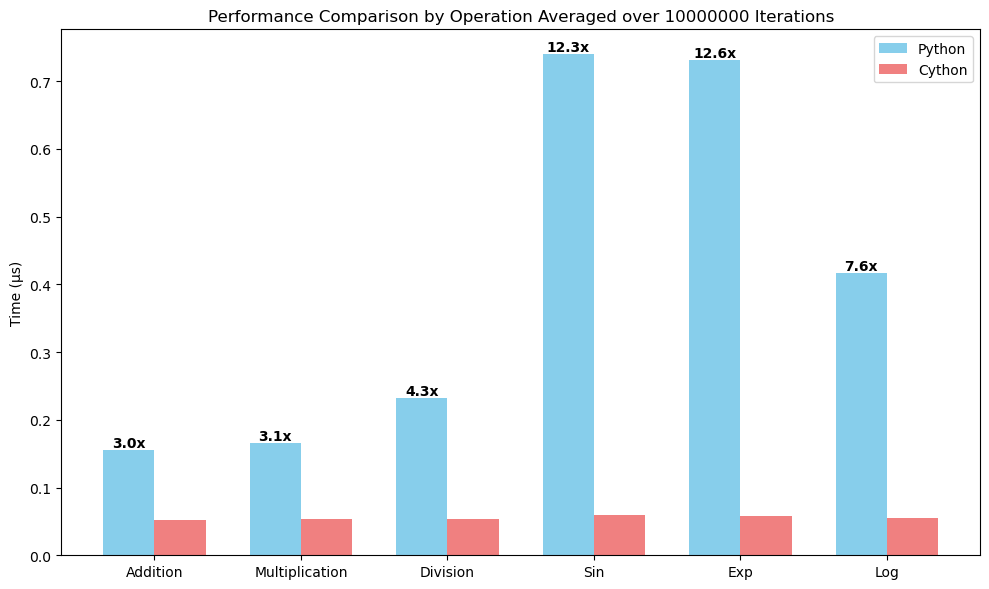

In [25]:
operations = ['Addition', 'Multiplication', 'Division', 'Sin', 'Exp', 'Log']
n_iter = 10_000_000

# Time each operation for both implementations
py_times = []
cy_times = []

# Python timing
x_py = df.Dual(2.0, 1.0)
y_py = df.Dual(3.0, 1.0)
py_times.extend([
    timeit.timeit(lambda: x_py + y_py, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_py * y_py, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_py / y_py, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_py.sin(), number=n_iter) / n_iter,
    timeit.timeit(lambda: x_py.exp(), number=n_iter) / n_iter,
    timeit.timeit(lambda: x_py.log(), number=n_iter) / n_iter
])

# Cython timing
x_cy = dfx.Dual(2.0, 1.0)
y_cy = dfx.Dual(3.0, 1.0)
cy_times.extend([
    timeit.timeit(lambda: x_cy + y_cy, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_cy * y_cy, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_cy / y_cy, number=n_iter) / n_iter,
    timeit.timeit(lambda: x_cy.sin(), number=n_iter) / n_iter,
    timeit.timeit(lambda: x_cy.exp(), number=n_iter) / n_iter,
    timeit.timeit(lambda: x_cy.log(), number=n_iter) / n_iter
])

# Convert to microseconds
py_times = np.array(py_times) * 1e6
cy_times = np.array(cy_times) * 1e6

# Create bar chart
x = np.arange(len(operations))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, py_times, width, label='Python', color='skyblue')
rects2 = ax.bar(x + width/2, cy_times, width, label='Cython', color='lightcoral')

ax.set_ylabel('Time (µs)')
ax.set_title('Performance Comparison by Operation Averaged over {} Iterations'.format(n_iter))
ax.set_xticks(x)
ax.set_xticklabels(operations)
ax.legend()


speedups = py_times / cy_times
for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            f'{speedups[i]:.1f}x',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

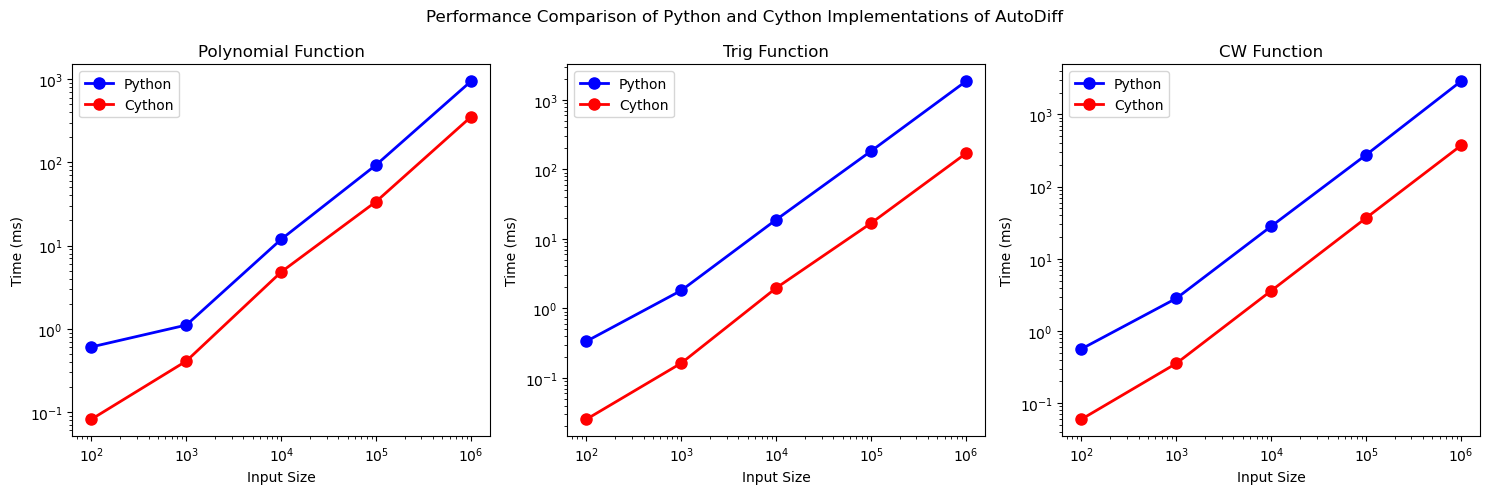

In [29]:
#AutoDiff Comparison

# Create performance visualization
sizes = [100, 1000, 10000, 100000, 1000000]
functions = ['Polynomial', 'Trig', 'CW']
py_times = np.zeros((len(functions), len(sizes)))
cy_times = np.zeros((len(functions), len(sizes)))

for i, func_name in enumerate(functions):
    for j, size in enumerate(sizes):
        x = np.linspace(0.5, 2.0, size)
        
        if func_name == 'Polynomial':
            f = lambda x: x**2 + 2*x + 1
        elif func_name == 'Trig':
            f = lambda x: x.sin() * x.cos()
        else:  # Complex
            f = lambda x: x.sin().log() + x**2 * x.cos()
        
        # Time Python version
        start = time.perf_counter()
        _ = df.autodiff(f, x)
        py_time = time.perf_counter() - start
        py_times[i, j] = py_time * 1000  # Convert to ms
        
        # Time Cython version
        start = time.perf_counter()
        _ = dfx.autodiff(f, x)
        cy_time = time.perf_counter() - start
        cy_times[i, j] = cy_time * 1000  # Convert to ms

# Create visualization
plt.figure(figsize=(15, 5))
for i, func in enumerate(functions):
    plt.subplot(1, 3, i+1)
    plt.loglog(sizes, py_times[i], 'b-o', label='Python', linewidth=2, markersize=8)
    plt.loglog(sizes, cy_times[i], 'r-o', label='Cython', linewidth=2, markersize=8)
    plt.grid(False)
    plt.title(f'{func} Function')
    plt.xlabel('Input Size')
    plt.ylabel('Time (ms)')
    plt.legend()

plt.suptitle('Performance Comparison of Python and Cython Implementations of AutoDiff')
plt.tight_layout()
plt.grid(False)
plt.show()


In [50]:
def complex_function(x):
    """f(x) = log(sin(x)) + x²cos(x)"""
    if isinstance(x, (df.Dual, dfx.Dual)):
        return x.sin().log() + x**2 * x.cos()
    else:
        return np.log(np.sin(x)) + x**2 * np.cos(x)

# Calculate analytical derivative using SymPy
x = sp.Symbol('x')
f = sp.log(sp.sin(x)) + x**2 * sp.cos(x)
f_prime = sp.diff(f, x)
analytical_derivative = float(f_prime.subs(x, 1.5))

def SymPy_full_derivative(x):
    x = sp.Symbol('x')
    f = sp.log(sp.sin(x)) + x**2 * sp.cos(x)
    f_prime = sp.diff(f, x)
    return float(f_prime.subs(x, 1.5)) 

# Step size comparison
step_sizes = np.logspace(-16, 0, 100)
numerical_gradients = []

for h in step_sizes:
    numerical_der = (complex_function(1.5 + h) - complex_function(1.5)) / h
    numerical_gradients.append(numerical_der)

# Calculate dual number derivatives
dual_derivative = df.autodiff(complex_function, 1.5)
dual_x_derivative = dfx.autodiff(complex_function, 1.5)


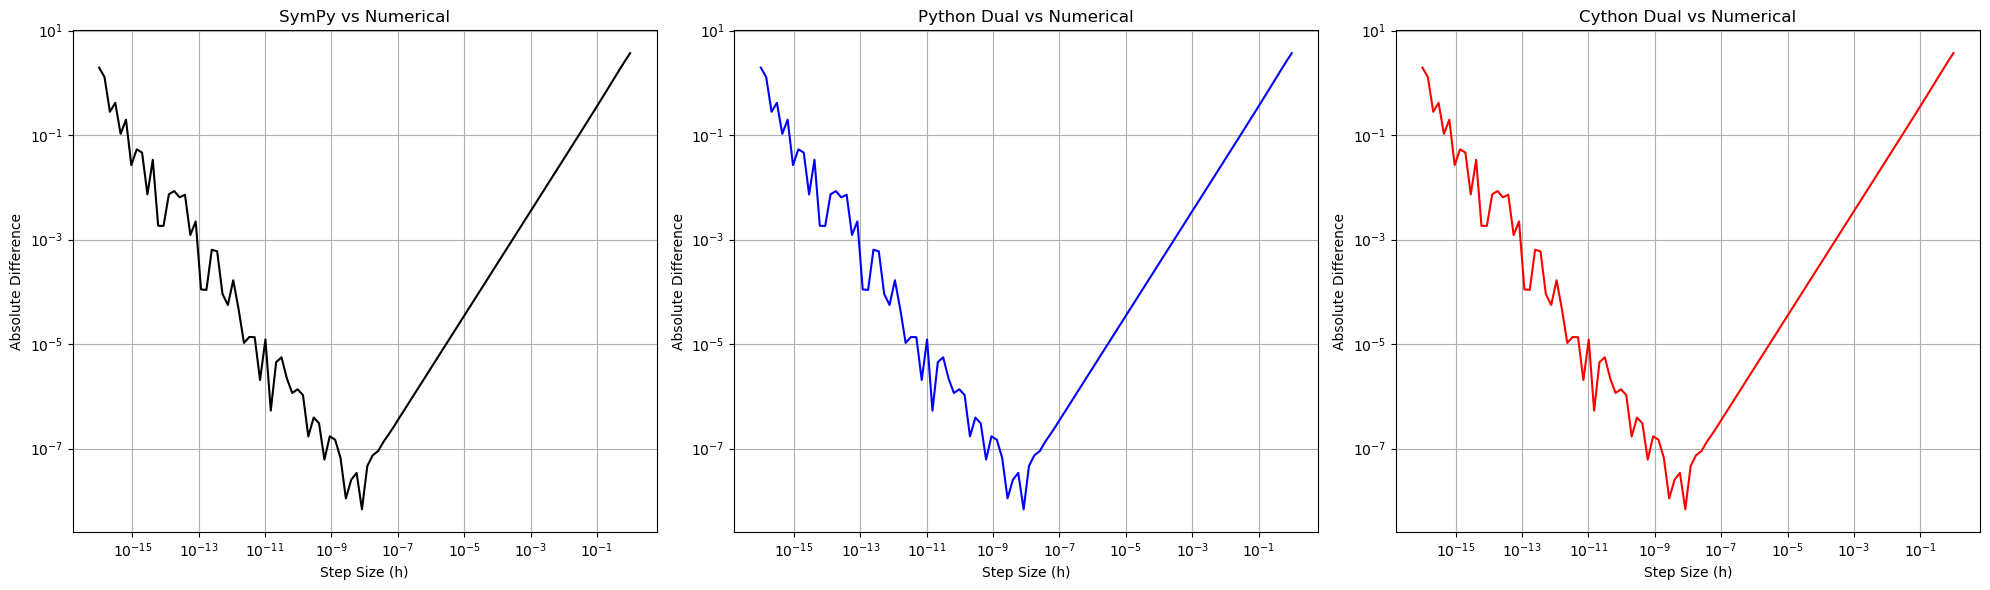

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))


ax1.semilogx(step_sizes, np.abs(numerical_gradients - analytical_derivative*np.ones(100)), 'k-')
ax1.grid(True)
ax1.set_xlabel('Step Size (h)')
ax1.set_ylabel('Absolute Difference')
ax1.set_yscale('log')
ax1.set_title('SymPy vs Numerical')


# Second plot - Python Dual vs Numerical
ax2.semilogx(step_sizes, np.abs(numerical_gradients - dual_derivative*np.ones(100)), 'b-')
ax2.grid(True)
ax2.set_xlabel('Step Size (h)')
ax2.set_ylabel('Absolute Difference')
ax2.set_yscale('log')
ax2.set_title('Python Dual vs Numerical')


# Third plot - Cython Dual vs Numerical
ax3.semilogx(step_sizes, np.abs(numerical_gradients - dual_x_derivative*np.ones(100)), 'r-')
ax3.grid(True)
ax3.set_xlabel('Step Size (h)')
ax3.set_ylabel('Absolute Difference')
ax3.set_yscale('log')
ax3.set_title('Cython Dual vs Numerical')


plt.tight_layout()
plt.show()

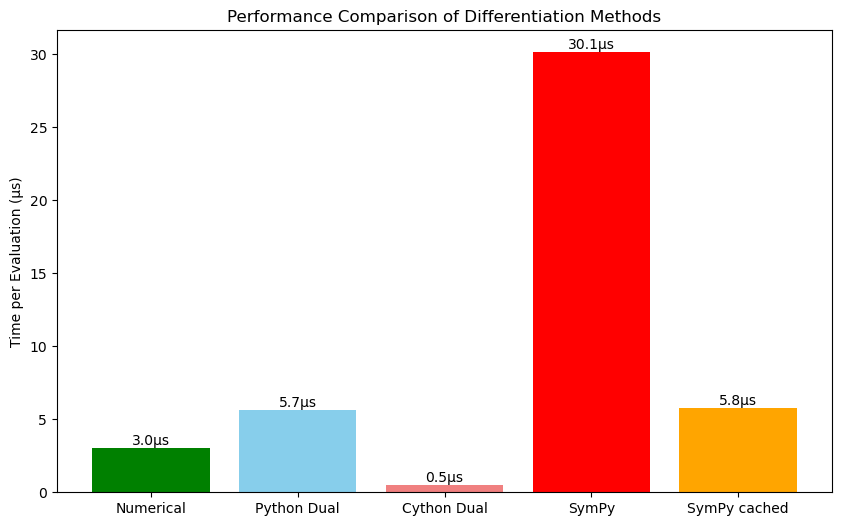

In [56]:
n_iter = 10000
methods = ['Numerical', 'Python Dual', 'Cython Dual', 'SymPy', 'SymPy cached']

times = []


times.append(timeit.timeit(lambda: (complex_function(1.5 + 1e-8) - complex_function(1.5)) / 1e-8, 
                          number=n_iter) / n_iter)


times.append(timeit.timeit(lambda: df.autodiff(complex_function, 1.5), 
                          number=n_iter) / n_iter)

times.append(timeit.timeit(lambda: dfx.autodiff(complex_function, 1.5), 
                          number=n_iter) / n_iter)

times.append(timeit.timeit(lambda: SymPy_full_derivative(1.5),
                            number=n_iter) / n_iter)

# SymPy cached
times.append(timeit.timeit(lambda: float(f_prime.subs(x, 1.5)), 
                          number=n_iter) / n_iter)

times = np.array(times) * 1e6

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, times, color=['green', 'skyblue', 'lightcoral', 'red', 'orange'])

plt.ylabel('Time per Evaluation (μs)')
plt.title('Performance Comparison of Differentiation Methods')

# Add time values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}μs',
             ha='center', va='bottom')
